# Wczytywanie danych medycznych
Opracowanie: A.Florkowska
\
Repozytorium: https://github.com/aflorkowska/Image-Processing/tree/main

In [1]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.ndimage
import matplotlib.pyplot as plt
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from IPython.display import Image

# Co to jest DICOM?
DICOM to standardowy format używany do zapisywania, przechowywania, czy przesyłania medycznych danych obrazowych, takich jak MRI czy CT. 

Standard DICOM definiuje sposób kodowania danych obrazowych i metadanych (informacje o pacjencie protkoły badania, informacje o urządzeniu etc). Zapewnia to zachowanie spójności zapisu, przy jednoczesnym użytkowaniu sprzętu od różnych dostawców.

Co więcej, DICOM to obrazy 16-bitowe (z wartościami w zakresie od -32768 do 32767), podczas gdy obrazy 8-bitowe w skali szarości przechowują wartości tylko z zakresu od 0 do 255. 

Dataset.file_meta -------------------------------
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: "['ORIGINAL', 'PRIMARY', 'AXIAL']"
(0008, 0016) SOP Class UID                       UI: 80e30f500244
(0008, 0018) SOP Instance UID                    UI: 0aef8620785f
(0008, 0060) Modality                            CS: 'CT'
(0018, 0050) Slice Thickness                     DS: '1.25'
(0018, 0060) KVP                                 DS: '120.0'
(0018, 1120) Gantry/Detector Tilt                DS: '0.0'
(0018, 1130) Table Height                        DS: '172.5'
(0018, 1140) Rotation Direction                  CS: 'CW'
(0018, 1151) X-Ray Tube Current                  IS: '747'
(0018, 1152) Exposure                            IS: '6'
(0018, 1210) Convolution Kernel                  SH: 'STANDARD

C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '80e30f500244'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '0aef8620785f'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '00268ff88746'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\agnie\anaconda3\envs\imaging\Lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '75d23269adbd'. Please see <https:/

Text(0.5, 1.0, 'CT')

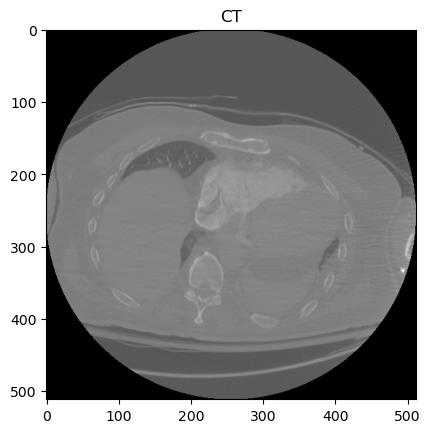

In [2]:
imageCT = pydicom.read_file(".././images/example2.dcm")
print(imageCT)

plt.imshow(imageCT.pixel_array, cmap='gray')
plt.title("CT")

# Tomografia komputerowa

Podczas pracy z danymi z tomografii komputerowej (CT) kluczowe znaczenie ma odpowiednie zrozumienie tego co te dane właściwie przedstawiają. 

Tomografia komputerowa to metoda diagnostyczna wykorzystujące promieniowanie rentgenowskie w celu uzyskania wielowarstkowych, przekrojowych obrazów ciała. Promieniowanie rentgenowskie (inaczej X) to rodzaj promieniowania elektromagnetycznego, które jest generowane podczas wyhamowywania elektronów (ogrzana katoda uwalnia elektrony o wysokiej energii, które z kolei uwalniają swoją energię w postaci promieniowania rentgenowskiego). Promienie rentgenowskie przechodzą przez tkanki i uderzają w detektor po drugiej stronie, z tym, że różne tkanki absorbują różne ilości promieniowania. 

Ogólna zasada jest taka: im gęstsza jest tkanka, tym więcej pochłania promieni rentgenowskich. Przykładowo, kość pochłania ich dużo, na detektor dociera mała ilość promieniowania co przekłada się na obraz biały. Z kolei powietrze nie pochłania tego promieniowania, innymi słowy duża ilość promieniowania dociera do detektora co przekłada się na obraz czarny.

Obecne wykorzystywane są urządzenia spiralnej tomografii komputerowej. Taka maszyna składa się z pojedynczego źródła promieniowania z wieloma detektorami, które obracają się wokół pacjenta, uzyskując blok danych w miarę przemieszczania wokół niego. Uzyskane informacje można zrekonstruować komputerowo w celu utworzenia „objętości” 3D, którą można następnie „pociąć” cyfrowo w celu uzyskania cieńszych przekrojów, a także przekrojów w różnych płaszczyznach anatomicznych: czołowa (coronal), strzałkowa (sagital) i poprzeczna (axial). 

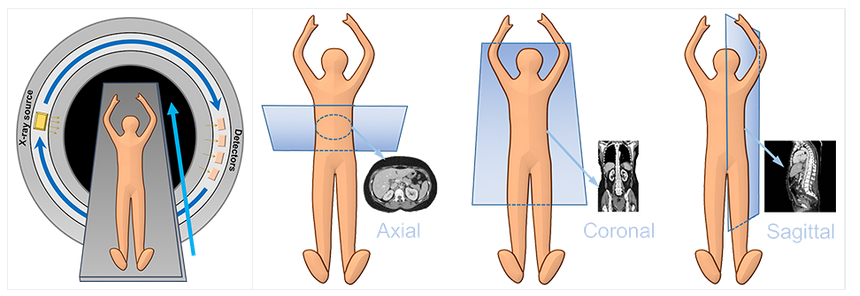

In [8]:
Image(filename=".././images/9_2.png", width=800)
# Source: https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained

# Fazy skanowania

Fazy ​​skanowania odnoszą się do momentu wykonania zdjęć w stosunku do czasu podania kontrastu. Kontrast dożylny stosuje się w tomografii komputerowej w celu uwidocznienia naczyń krwionośnych i wzmocnienia struktury tkanek różnych narządów, takich jak mózg, kręgosłup, wątroba i nerki. „Dożylne” oznacza, że ​​kontrast wstrzykuje się do żyły za pomocą małej igły. W niektórych badaniach obrazowych jamy brzusznej i układu żołądkowo-jelitowego dla uzyskania maksymalnej czułości wykorzystuje się zarówno dożylnie jod, jak i doustnie podawany kontrast barowy.

Kolejno występują fazy:
- Faza bez kontrastu - stanowi punkt odniesienia, zazwyczaj do oceny struktur anatomicznych jak kości
- Faza tętnicza - skanowanie przeprowadza się kilka sekund po podaniu środka kontrastującego, przydatne w ocenie naczyń krwionośnych (tętnice mózgowe, wieńcowe) czy diagnostyce guzów o wysokim ukrwieniu (np. w wątrobie czy trzustce)
- Faza żylna - skanowanie przeprowadza się 60-70 sekund po podaniu środka kontrastującego, przydatna do oceny narządów jamy brzusznej m.in. wątroby
- Faza równomierna - skanowanie kilka minut po podaniu kontrastu, użyteczna do oceny zmian o charakterze zapalnym  
- Faza opóźniona - skanowanie kilka godzin po podaniu kontrastu, przydatne podczas diagnostyki układu moczowego np. obrazowanie nerek, moczowodów i pęcherza moczowego.

Podsumowując, obrazowanie metodą tomografii komputerowej pozwala na uzyskanie obrazów strukturalnych, takich jak kości i tkanki miękkie. W efekcie, dane z CT przedstawiają gęstość radiologiczną, wyrażona w jednostkach skali Hounsfielda (HU). 

# Skala Hounsfielda

Skala jednostek Hounsfielda jest liniowym przekształceniem pierwotnego pomiaru liniowego współczynnika osłabienia, w której gęstość radiologiczna wody destylowanej w standardowej temperaturze i ciśnieniu (warunki standardowe) jest definiowana jako 0 HU, natomiast gęstość powietrza w warunkach standardowych jest określana jako -1000 HU. 

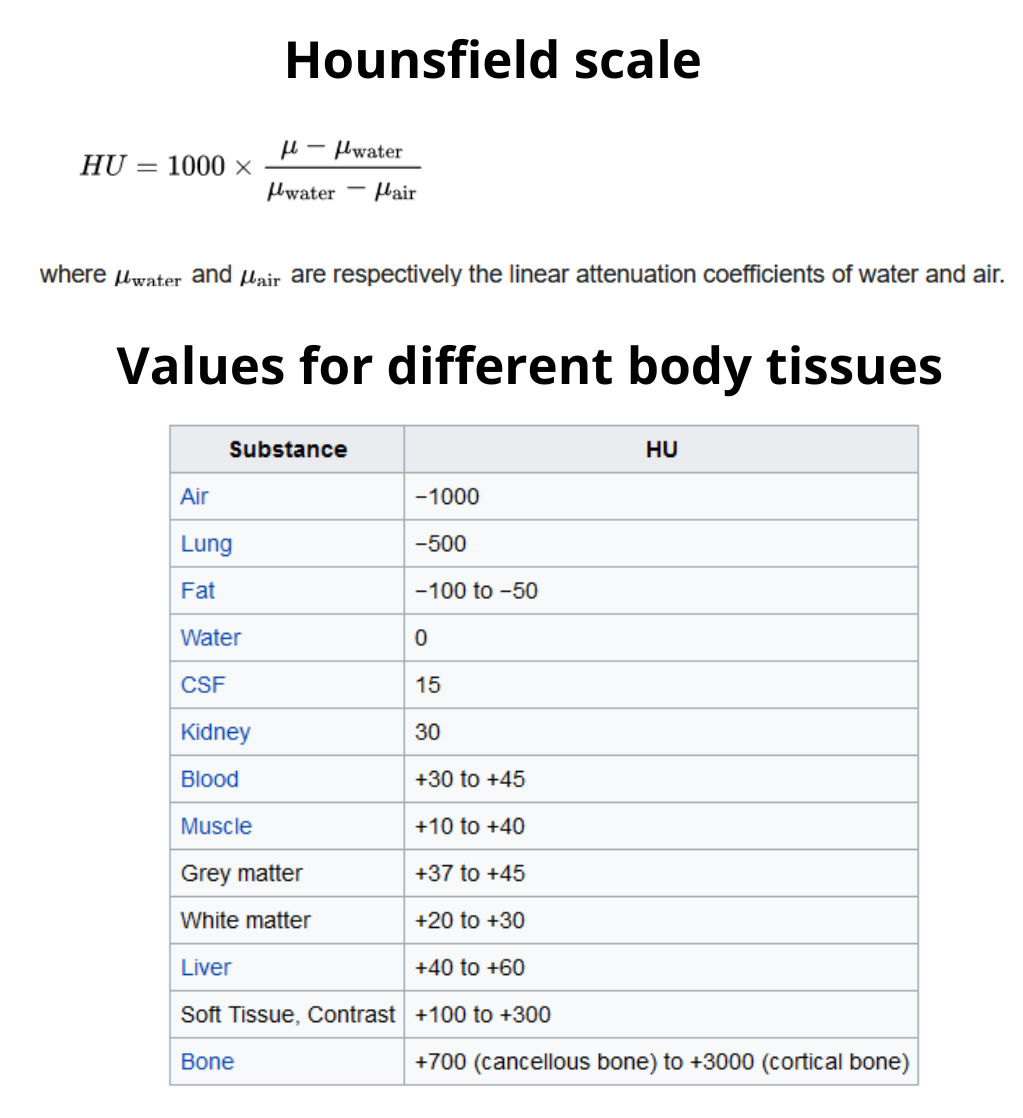

In [13]:
Image(filename=".././images/9_1.png", width=500)
# Source: https://en.wikipedia.org/wiki/Hounsfield_scale

# Konwersja wartości do jednostek w skali Hounsfielda

Wspomniane wcześniej zakresy wartości w DICOM są przydatne, ponieważ korelują ze skalą Hounsfielda. Na początku należy wartości pikseli przekształcić na odpowiadające jednostki w skali Hounsfielda. W obliczeniach wykorzystuje się z 2 tagi z metadanych pliku DICOM: wartości pikseli mnoży się wartości przez nachylenie (RescaleSlope) oraz dodaje punkt przecięcia (RescaleIntercept).

Niektóre skanery mają cylindryczne granice skanowania, jednakże ich obraz wyjściowy jest kwadratowy. Piksele wykraczające poza te granice otrzymują stałą wartość -2000. Jako, że wartość punktu przecięcia (RescaleIntercept) wynosi zazwyczaj -1024 a nachylenie (RescaleSlope) 1, to wartość powietrza odpowiada średnio wartości 0. Właśnie dlatego wartości poza tymi granicami skanowania przyjmują wartość 0.

Poniżej przedstawiono histogramu wczytanego obrazu DICOM. 

Text(0.5, 1.0, 'Histogram')

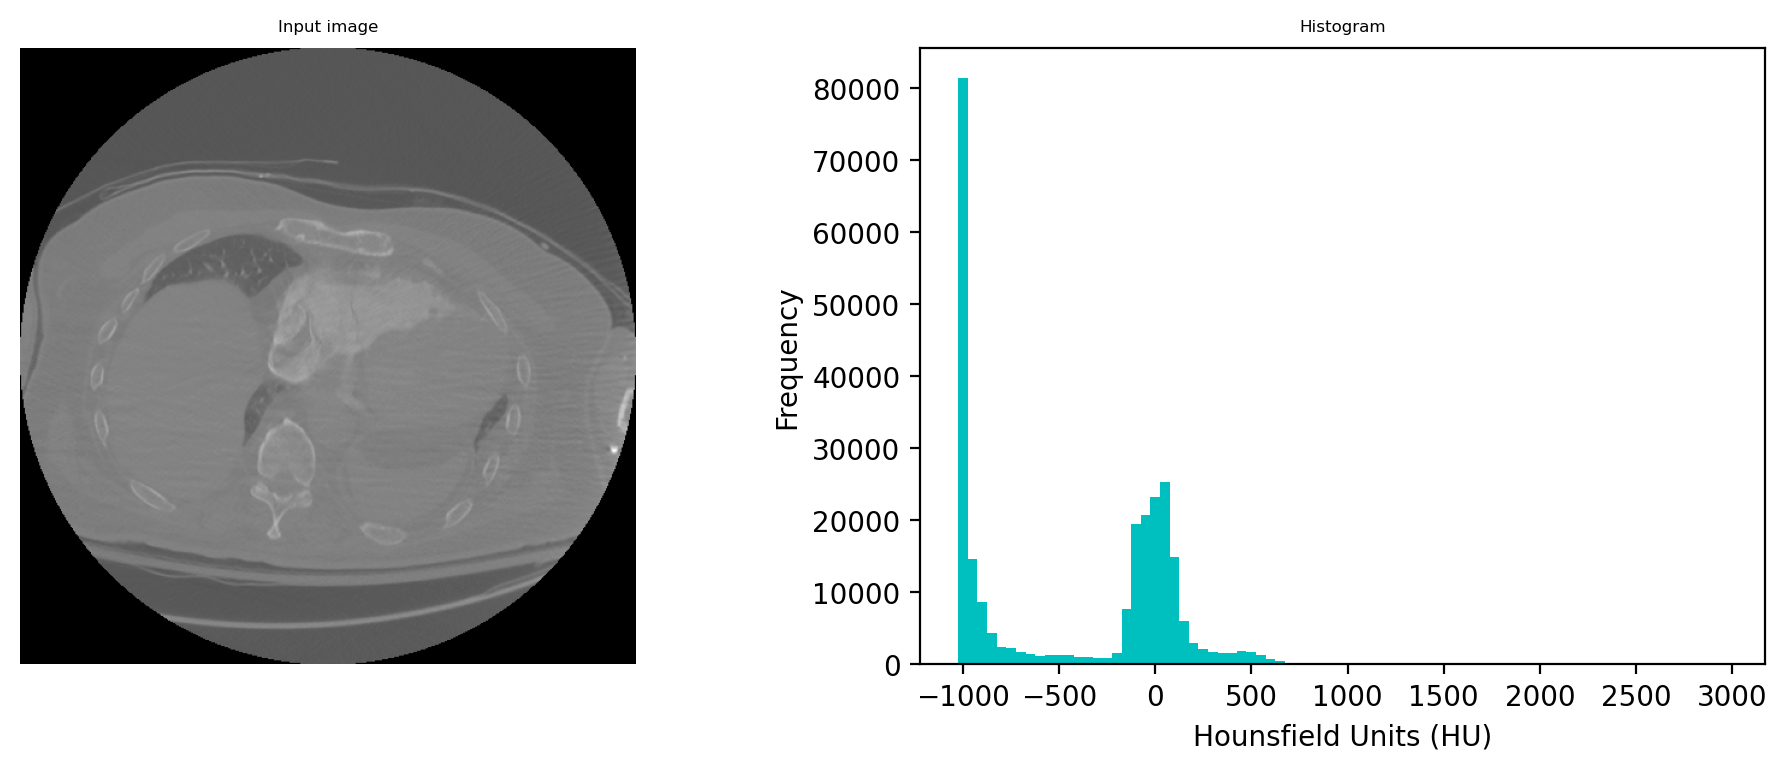

In [3]:
def get_pixels_hu(image):
    inputImage = image.pixel_array
    inputImage = inputImage.astype(np.int16)
    inputImage[inputImage == -2000] = 0

    intercept = image.RescaleIntercept
    slope = image.RescaleSlope
    
    if slope != 1:
        inputImage = slope * inputImage.astype(np.float64)
        inputImage = inputImage.astype(np.int16)
        
    inputImage += np.int16(intercept)
    
    return np.array(inputImage, dtype=np.int16)

imageHU = get_pixels_hu(imageCT)

plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(imageCT.pixel_array, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 2, 2)
plt.hist(imageHU.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.title("Histogram", fontsize=6)

# Ponowne próbkowanie danych

Dane zapisane w formacie DICOM zawierają wiele metadanych m.in. informacje o grubości piksela (slice thickness) oraz odległości między kolejnymi pikselami (pixel spacing). W praktyce może się zdarzyć, że wartości tych tagów są zależne od skanów, co może negatywnie wpłynać na wydajność np. podczas analizy przy użyciu konwolucyjnych sieci neuronowych. Na szczęście można temu zaradzić, poprzez ponownie próbkowanie, zazwyczaj do rozmiarów 1 mm x 1mm x 1mm.

In [4]:
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]  
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    print(f"Calculated slice thickness is equal to {slice_thickness}, when slice thickness tag is {slices[0].SliceThickness}.") 
    
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    spacing = [scan[0].SliceThickness] + list(scan[0].PixelSpacing)
    spacing = np.array(list(spacing))
    resize_factor = spacing / new_spacing
    image = scipy.ndimage.interpolation.zoom(image, resize_factor)
    return image
    
example_patient_data = load_scan(".././images/CTdata")
example_patient_dataHU = get_pixels_hu(example_patient_data)
example_patient_dataHU_resampled= resample(example_patient_dataHU, example_patient_data, [1,1,1])

print(f"\n\nSlice thickness {example_patient_data[0].SliceThickness}, and pixel spacing {example_patient_data[0].PixelSpacing}.") 
print(f"Shape before resampling {example_patient_dataHU.shape}, and after resampling {example_patient_dataHU_resampled.shape}.") 

Calculated slice thickness is equal to 1.25, when slice thickness tag is 1.250000.


C:\Users\agnie\AppData\Local\Temp\ipykernel_19816\1626408024.py:34: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, resize_factor)




Slice thickness 1.25, and pixel spacing [0.802734, 0.802734].
Shape before resampling (232, 512, 512), and after resampling (290, 411, 411).


# Wyświetlanie danych 3D

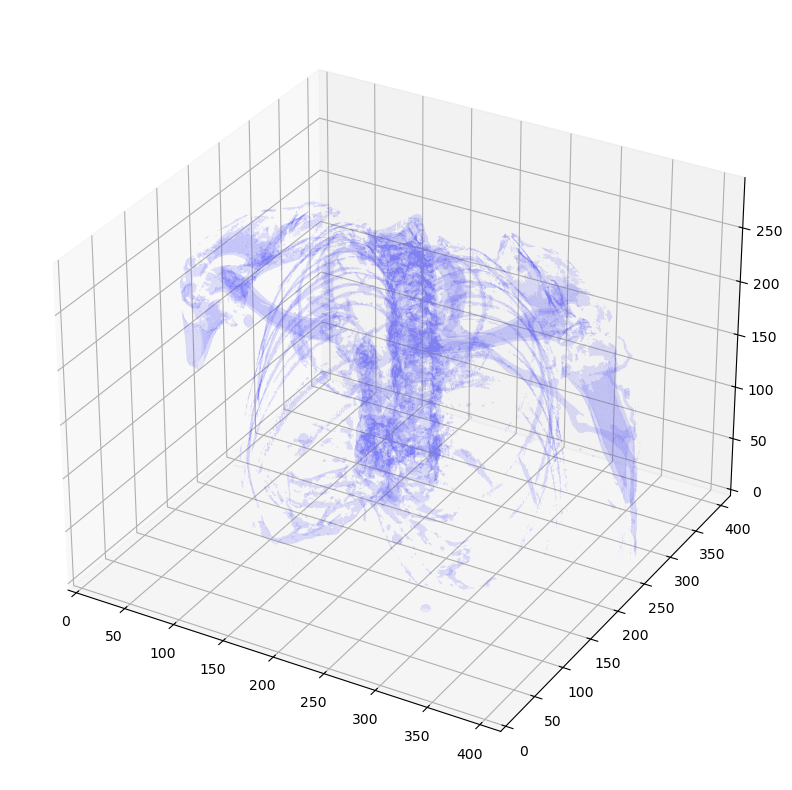

In [6]:
def plot_3d(image, threshold=-300):
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces,_,_ = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

plot_3d(example_patient_dataHU_resampled, 600)

# Okienkowanie

Okienkowanie to proces manipulacji kontrastem i jasnością obrazu w formacie DICOM w celu podkreślenia poszczególnych struktur. Jest to kluczowy etap umożliwiający poprawę czytelności obrazów, tym samym dokładniejszą interpretację obrazów medycznych przez lekarzy.

Wartości danych w formacie DICOM są skorelowane z jednostkami Hounsfielda. Poniższa skala przedstawia zależność pomiędzy różnymi rodzajami tkanek, ze względu na ich gęstość.  

Powietrze < Tłuszcz < Płyn < Tkanka miękka < Kość < Metal

Dlaczego?
- Powietrze ma najmniejszą gęstość.
- Tłuszcz unosi się na wodzie, więc ma mniejszą gęstość niż płyn.
- Tkanka miękka to głównie płyn wewnątrzkomórkowy z niewielką ilością tkanki łącznej.
- Kość jest gęstszą strukturą niż tkanka.

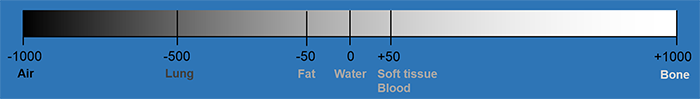

In [10]:
Image(filename=".././images/9_3.png", width=800)
# Source: https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained

Najpierw należy określić okno. Definiowane jest ono przez poziom (window level, WL) oraz szerokość (window width, WW), które kolejno regulują jasnością i kontrastem obrazu. Wartości okna zapisywane są jako (WW:x WL:y) w jednostkach Hounsfielda (HU).

Przykładowo, okno o poziomie 0 HU i szerokości 400 HU będzie miało zakres od -200 HU do +200 HU. Każda tkanka o gęstości -200 HU lub mniejszej będzie czarna, a każda tkanka o gęstości +200 HU lub większej będzie biała. Natomiast wartości od -200 HU do +200 HU będą rozłożone w całym zakresie skali szarości. Można ustawić okno tak, aby uwypuklało ono określone tkanki. W efekcie, wybrany zakres gęstości tkanki (nawet niewielki) jest reprezentowany przez pełne widmo w skali szarości od czerni do bieli. Dzięki temu nawet drobne różnice gęstości w określonym zakresie są lepiej widoczne.

Po przedstawieniu szerokości okna (WW) i poziomu okna (WL) można obliczyć górny i dolny poziom szarości, tj. wartości powyżej górnej granicy będą białe, a wartości poniżej dolnej granicy będą czarne.
- górny poziom szarości obliczany jest poprzez WL + (WW ÷ 2)
- dolny poziom szarości liczony jest poprzez WL - (WW ÷ 2)

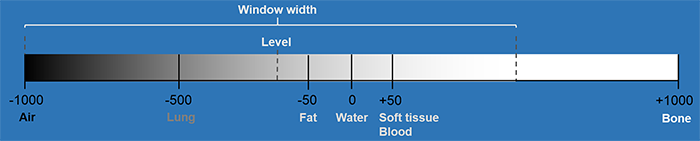

In [12]:
Image(filename=".././images/9_4.png", width=800)
# Source: https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained

Text(0.5, 1.0, 'Input image after windowing for soft tissue [WL = 50, WL = 350]')

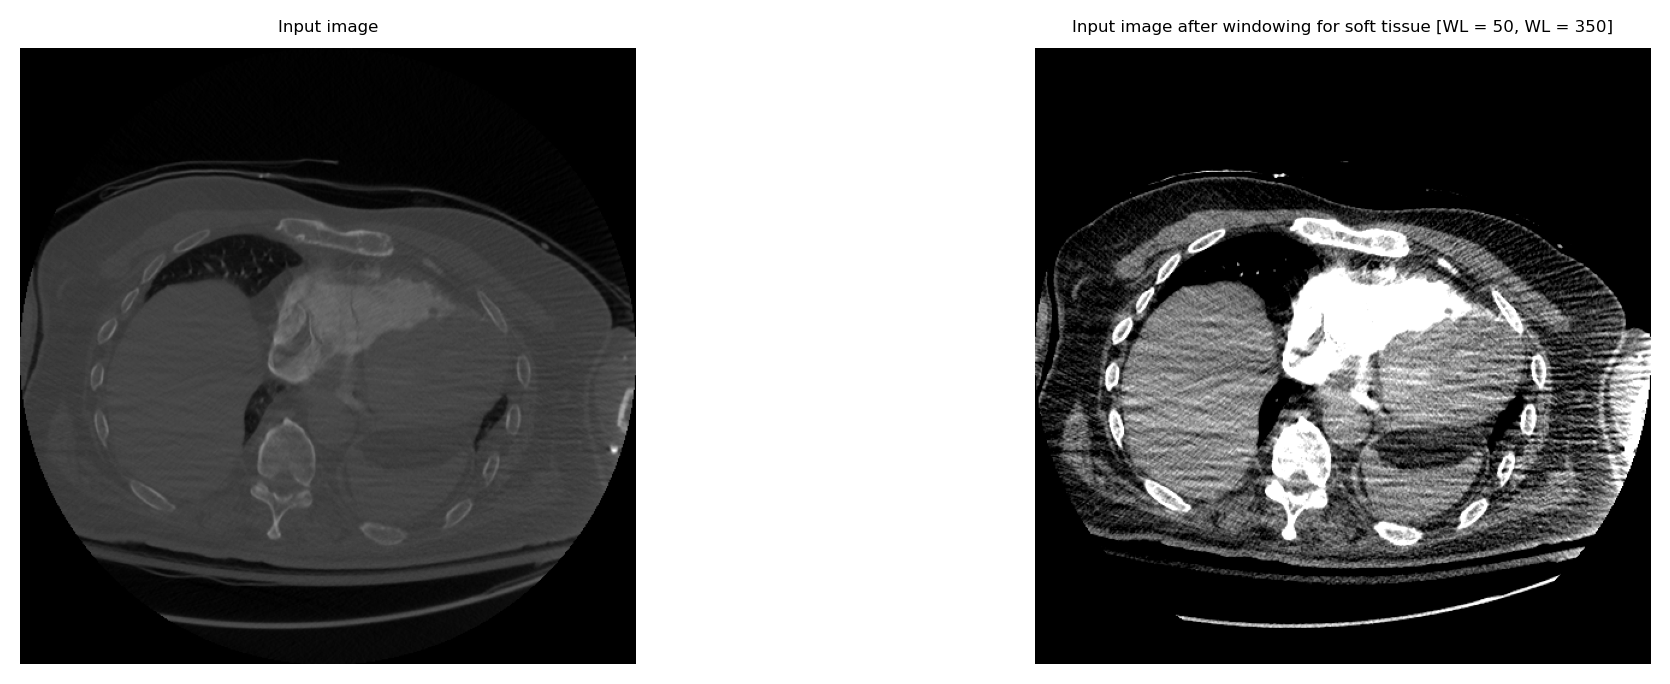

In [5]:
def window_image(imgInHU, window_center, window_width, rescale=True): 
    output_image = imgInHU.copy();
    lower_boundary = window_center - window_width // 2 
    upper_boundary = window_center + window_width // 2 
    output_image[output_image < lower_boundary] = lower_boundary 
    output_image[output_image > upper_boundary] = upper_boundary 
    if rescale: 
        output_image = (output_image - lower_boundary) / (upper_boundary - lower_boundary) * 255.0 
    return output_image

imageHU_windowed = window_image(imageHU, 50, 350)

plt.figure(figsize=(12, 4), dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(imageHU, cmap='gray')
plt.axis('off')
plt.title("Input image", fontsize=6)
plt.subplot(1, 2, 2)
plt.imshow(imageHU_windowed, cmap='gray')
plt.axis('off')
plt.title("Input image after windowing for soft tissue [WL = 50, WL = 350]", fontsize=6)

# Normalizacja vs centralizacja do środka vs standaryzacja 

Dane DICOM można analizować m.in. przy użyciu głębokich sieci neuronowych. W celu przyśpieszenia czasu trwania trenowania algorytmów i uzyskania dobrej generalizacji można zastosować poniższe metody modyfikacji rozkładu danych:
- normalizacja - proces zmiany zakresu wartości intesywności pikseli do zakresu [0, 1]. 
- centralizacja do środka - proces modyfikacja danych, tak aby średnia wynosiła 0. Może być wykonana przed i po normalizacji (różni się zakresem wartości). W przypadku korzystania z funkcji aktywacji Sigmoid lub ReLU preferowane jest centrowanie danych, ponieważ pozwala to uniknąć nasycenia gradientem. Zjawisko to występuje, gdy gradienty dążą do zera podczas opadania gradientu.
- standaryzacja - technika skalowania danych modyfikująca rozkład danych na gaussowski. Innymi słowy przesuwa rozkład danych tak, aby średnia wynosiła 0, a odchylenie standardowe 1. 

Można wyróżnić kilka typów centralizacji oraz standaryzacji danych, w zależności od sposobu liczenia mediany i odchylenia standaryzacji:
- dla całych danych
- dla pojedynczej grupy (batcha)
- dla pojedynczej próbki
- dla pojedynczego kanału z osobna (np. przy danych RGB) 

In [16]:
# Examples of performing the described techniques on the single image

normalize = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image)) 
standarize = lambda image, mean, std: (image - mean) / std 
centralize = lambda image, mean: image - mean 

print(f"Properties of input image: min value: {imageHU_windowed.min()}, max value: {imageHU_windowed.max()}, mean {np.mean(imageHU_windowed)}, and std {np.std(imageHU_windowed)}.\n") 

normalized_imageHU_windowed = normalize(imageHU_windowed)
print(f"Properties after normalization: {normalized_imageHU_windowed.min()}, max value: {normalized_imageHU_windowed.max()}, mean {np.mean(normalized_imageHU_windowed)}, and std {np.std(normalized_imageHU_windowed)}.\n")  

centalized_imageHU_windowed = centralize(imageHU_windowed, np.mean(imageHU_windowed))
normalized_centalized_imageHU_windowed = normalize(centalized_imageHU_windowed)
print(f"Properties after normalization of centralized input image: {normalized_centalized_imageHU_windowed.min()}, max value: {normalized_centalized_imageHU_windowed.max()}, mean {np.mean(normalized_centalized_imageHU_windowed)}, and std {np.std(normalized_centalized_imageHU_windowed)}.\n")  
centalized_normalized_imageHU_windowed = centralize(normalized_imageHU_windowed, np.mean(normalized_imageHU_windowed))
print(f"Properties after centralization of normalized image: {centalized_normalized_imageHU_windowed.min()}, max value: {centalized_normalized_imageHU_windowed.max()}, mean {np.mean(centalized_normalized_imageHU_windowed)}, and std {np.std(centalized_normalized_imageHU_windowed)}.\n")  

standardized_imageHU_windowed = standarize(imageHU_windowed, np.mean(imageHU_windowed), np.std(imageHU_windowed))
print(f"Properties after standarization: {standardized_imageHU_windowed.min()}, max value: {standardized_imageHU_windowed.max()}, mean {np.mean(standardized_imageHU_windowed)}, and std {np.std(standardized_imageHU_windowed)}.\n")  


Properties of input image: min value: 0.0, max value: 255.0, mean 56.2894718170166, and std 77.1012067643713.

Properties after normalization: 0.0, max value: 1.0, mean 0.22074302673339846, and std 0.3023576735857698.

Properties after normalization of centralized input image: 0.0, max value: 1.0, mean 0.22074302673339846, and std 0.3023576735857698.

Properties after centralization of normalized image: -0.22074302673339846, max value: 0.7792569732666015, mean 9.540979117872439e-18, and std 0.3023576735857698.

Properties after standarization: -0.7300725135086749, max value: 2.5772687163024814, mean 7.632783294297951e-17, and std 1.0000000000000002.



# Źródła
- Wyjaśnione okienkowanie: https://www.kaggle.com/code/redwankarimsony/ct-scans-dicom-files-windowing-explained
- Wyjaśnienie normalizacji, zero centrowania i standaryzacji danych: https://www.imaios.com/en/resources/blog/ct-images-normalization-zero-centering-and-standardization
- Pełen tutorial wstępnego przetworzenia danych: https://www.kaggle.com/code/joncarlisle/full-preprocessing-tutorial